In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from scipy.io import loadmat

from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights, alexnet, AlexNet_Weights
from timeit import default_timer as timer

C:\Users\guanq\AppData\Local\anaconda3\envs\4042Assign2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data Preparation

In [3]:
#train_set = torchvision.datasets.Flowers102(root="./dataset", split='train', download=True)
#val_set = torchvision.datasets.Flowers102(root="./dataset", split='val', download=True)
#test_set = torchvision.datasets.Flowers102(root="./dataset", split='test', download=True)

In [4]:
setid = loadmat('./dataset/flowers-102/setid.mat')
setid

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [5]:
idx_train = setid['trnid'][0] - 1
idx_test = setid['tstid'][0] - 1
idx_valid = setid['valid'][0] - 1

In [6]:
image_labels = loadmat('./dataset/flowers-102/imagelabels.mat')['labels'][0]
image_labels -= 1
image_labels

array([76, 76, 76, ..., 61, 61, 61], dtype=uint8)

In [7]:
import glob
files = sorted(glob.glob('./dataset/flowers-102/jpg/*.jpg'))
len(files)
labels = np.array(list(zip(files, image_labels)))

In [8]:
def write_set_file(fout, labels):
    with open(fout, 'w+') as f:
        for label in labels:
            f.write('%s %s\n' % (label[0], label[1]))

# Images are ordered by species, so shuffle them
np.random.seed(42)
idx_train = idx_train[np.random.permutation(len(idx_train))]
idx_test = idx_test[np.random.permutation(len(idx_test))]
idx_valid = idx_valid[np.random.permutation(len(idx_valid))]

write_set_file('train.txt', labels[idx_train,:])
write_set_file('test.txt', labels[idx_test,:])
write_set_file('valid.txt', labels[idx_valid,:])

# Data Processing

Choose the model name here

In [9]:
model_name = "resnet"
#model_name = "alexnet"
#model_name = "vgg"

Get the transform list

In [10]:
if model_name == "resnet":
    weight = ResNet50_Weights.DEFAULT
    auto_transform = weight.transforms()
    
elif model_name == "alexnet":
    weight = AlexNet_Weights.DEFAULT
    auto_transform = weight.transforms()
    
elif model_name == "vgg":
    weight = VGG16_Weights.DEFAULT
    auto_transform = weight.transforms()
    
else:
    print("Invalid model name, exiting...")
    exit()  

auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
class Flower102Dataset(Dataset):
    
    def __init__(self, txt_file,  transform):
        self.txt_file = txt_file
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }        

In [12]:
train_dataset = Flower102Dataset('./train.txt', auto_transform)
val_dataset = Flower102Dataset('./valid.txt', auto_transform)
test_dataset = Flower102Dataset('./test.txt', auto_transform)

In [13]:
NUM_WORKERS = 0
batch_size = 128

train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers = NUM_WORKERS)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = NUM_WORKERS)

# Model Initialization

Here we use ResNet50, AlexNet and VGG16

In [14]:
def initialize_model(model_name):
    model = None
    
    if model_name == 'resnet':
        model = resnet50(pretrained=True).to(device)
        for param in model.parameters():
            param.requires_grad = False
            
        model.fc = torch.nn.Linear(in_features=2048, out_features=102, bias=True).to(device)
        
    elif model_name == 'alexnet':
        model = alexnet(pretrained=True).to(device)
        for param in model.parameters():
            param.requires_grad = False

        model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=102, bias=True).to(device)
        
    elif model_name == 'vgg':
        model = vgg16(pretrained=True).to(device)
        for param in model.parameters():
            param.requires_grad = False
            
        model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=102, bias=True).to(device)
        
    else:
        print("Invalid model name, exiting...")
        exit()  
        
    return model

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = initialize_model(model_name)

C:\Users\guanq\AppData\Local\anaconda3\envs\4042Assign2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\guanq\AppData\Local\anaconda3\envs\4042Assign2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
summary(model=model,
       input_size=(128,3,244,244),
       verbose=0,
       col_names=["input_size", 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [128, 3, 244, 244]   [128, 102]           --                   Partial
├─Conv2d (conv1)                         [128, 3, 244, 244]   [128, 64, 122, 122]  (9,408)              False
├─BatchNorm2d (bn1)                      [128, 64, 122, 122]  [128, 64, 122, 122]  (128)                False
├─ReLU (relu)                            [128, 64, 122, 122]  [128, 64, 122, 122]  --                   --
├─MaxPool2d (maxpool)                    [128, 64, 122, 122]  [128, 64, 61, 61]    --                   --
├─Sequential (layer1)                    [128, 64, 61, 61]    [128, 256, 61, 61]   --                   False
│    └─Bottleneck (0)                    [128, 64, 61, 61]    [128, 256, 61, 61]   --                   False
│    │    └─Conv2d (conv1)               [128, 64, 61, 61]    [128, 64, 61, 61]    (4,096)              False
│    │    

# Task 1: Fine-tune the models to perform the classification task

In [17]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0
    
    for i, batch in enumerate(dataloader):
        X = batch['image']
        y = batch['label']
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_label==y).sum().item()/len(y_pred)
        
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

In [18]:
def val_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device: torch.device):
    model.eval()
    val_loss, val_acc = 0, 0
    
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):
            X = batch['image']
            y = batch['label']

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred,y)
            val_loss += loss.item()

            y_pred_label = y_pred.argmax(dim=1)
            val_acc += (y_pred_label==y).sum().item()/len(y_pred_label)
        
    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc

In [19]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, epochs: int, device: torch.device):
    
    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    model.to(device)
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
        valid_loss, valid_acc = val_step(model=model, dataloader = val_dataloader, loss_fn = loss_fn, device=device)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"valid_loss: {valid_loss:.4f} | "
          f"valid_acc: {valid_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    return results

In [20]:
num_classes = 102
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=2e-05)

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

result = train(model=model,
         train_dataloader= train_dataloader,
         val_dataloader= val_dataloader,
         optimizer=optimizer,
         loss_fn=loss_fn,
         epochs=15,
         device=device)

end_time = timer()

train_time = end_time - start_time
print(f"Training time for {model_name} is {train_time}")

  7%|█████▌                                                                             | 1/15 [00:22<05:10, 22.15s/it]

Epoch: 1 | train_loss: 4.5529 | train_acc: 0.0542 | valid_loss: 4.1525 | valid_acc: 0.1598


 13%|███████████                                                                        | 2/15 [00:45<04:59, 23.02s/it]

Epoch: 2 | train_loss: 3.7774 | train_acc: 0.3986 | valid_loss: 3.5216 | valid_acc: 0.4728


 20%|████████████████▌                                                                  | 3/15 [01:10<04:42, 23.58s/it]

Epoch: 3 | train_loss: 3.0513 | train_acc: 0.6874 | valid_loss: 2.9837 | valid_acc: 0.6316


 27%|██████████████████████▏                                                            | 4/15 [01:36<04:32, 24.81s/it]

Epoch: 4 | train_loss: 2.4376 | train_acc: 0.8529 | valid_loss: 2.5756 | valid_acc: 0.7169


 33%|███████████████████████████▋                                                       | 5/15 [02:03<04:14, 25.44s/it]

Epoch: 5 | train_loss: 1.9792 | train_acc: 0.9343 | valid_loss: 2.2820 | valid_acc: 0.7648


 40%|█████████████████████████████████▏                                                 | 6/15 [02:29<03:51, 25.70s/it]

Epoch: 6 | train_loss: 1.6590 | train_acc: 0.9745 | valid_loss: 2.0752 | valid_acc: 0.7933


 47%|██████████████████████████████████████▋                                            | 7/15 [02:56<03:27, 26.00s/it]

Epoch: 7 | train_loss: 1.4412 | train_acc: 0.9863 | valid_loss: 1.9304 | valid_acc: 0.8178


 53%|████████████████████████████████████████████▎                                      | 8/15 [03:22<03:02, 26.13s/it]

Epoch: 8 | train_loss: 1.2931 | train_acc: 0.9902 | valid_loss: 1.8279 | valid_acc: 0.8285


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [03:49<02:37, 26.26s/it]

Epoch: 9 | train_loss: 1.1913 | train_acc: 0.9931 | valid_loss: 1.7542 | valid_acc: 0.8421


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [04:22<02:21, 28.37s/it]

Epoch: 10 | train_loss: 1.1198 | train_acc: 0.9951 | valid_loss: 1.7000 | valid_acc: 0.8510


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [04:52<01:55, 28.83s/it]

Epoch: 11 | train_loss: 1.0683 | train_acc: 0.9970 | valid_loss: 1.6594 | valid_acc: 0.8588


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [05:21<01:26, 28.95s/it]

Epoch: 12 | train_loss: 1.0304 | train_acc: 0.9970 | valid_loss: 1.6285 | valid_acc: 0.8569


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [05:49<00:57, 28.66s/it]

Epoch: 13 | train_loss: 1.0017 | train_acc: 0.9990 | valid_loss: 1.6045 | valid_acc: 0.8569


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [06:15<00:27, 27.95s/it]

Epoch: 14 | train_loss: 0.9795 | train_acc: 1.0000 | valid_loss: 1.5857 | valid_acc: 0.8578


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:42<00:00, 26.86s/it]

Epoch: 15 | train_loss: 0.9621 | train_acc: 1.0000 | valid_loss: 1.5709 | valid_acc: 0.8578
Training time for resnet is 402.96060730004683


Save the models

In [22]:
MODEL_PATH = Path("./")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = f"flower_classification_{model_name}.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Analysis

In [23]:
result_df = pd.DataFrame(result)
result_df

,train_loss,train_acc,valid_loss,valid_acc
0,4.552925,0.054152,4.152544,0.159810
1,3.777423,0.398595,3.521617,0.472782
2,3.051254,0.687374,2.983726,0.631552
3,2.437556,0.852854,2.575597,0.716860
4,1.979163,0.934255,2.281954,0.764837
5,1.659020,0.974452,2.075240,0.793284
6,1.441157,0.986265,1.930372,0.817761
7,1.293149,0.990171,1.827935,0.828503
8,1.191316,0.993133,1.754207,0.842143
9,1.119795,0.995086,1.700037,0.850995


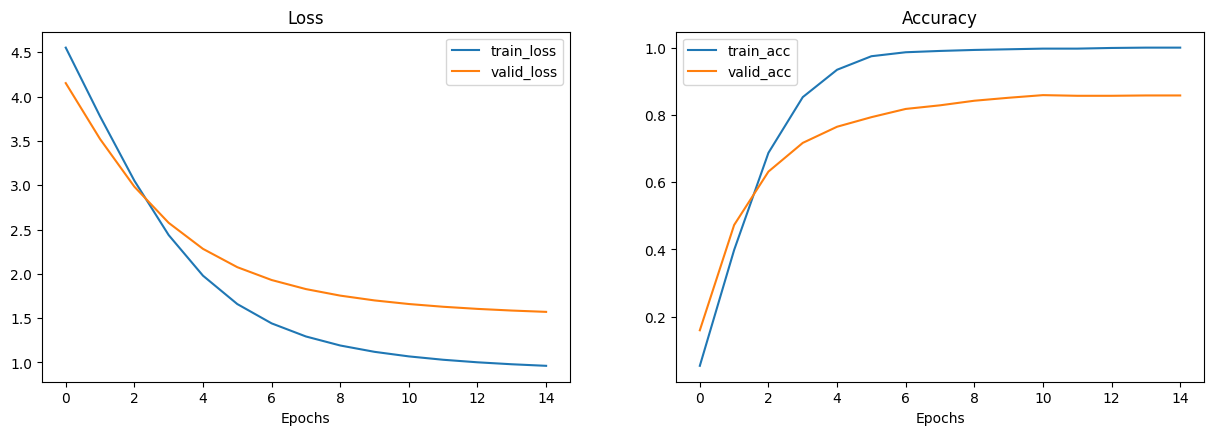

In [24]:
plt.figure(figsize=(15, 10))

epochs = 15

plt.subplot(2, 2, 1)
plt.plot(range(epochs), result_df["train_loss"], label="train_loss")
plt.plot(range(epochs), result_df["valid_loss"], label="valid_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), result_df["train_acc"], label="train_acc")
plt.plot(range(epochs), result_df["valid_acc"], label="valid_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

Performance on the test set

In [25]:
def test(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device: torch.device):
    
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for i, batch in enumerate(test_dataloader):
            X = batch['image']
            y = batch['label']

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred,y)
            test_loss += loss.item()

            y_pred_label = y_pred.argmax(dim=1)
            test_acc += (y_pred_label==y).sum().item()/len(y_pred_label)
        
    test_loss = test_loss/len(test_dataloader)
    test_acc = test_acc/len(test_dataloader)
    return test_loss, test_acc

In [26]:
test_loss, test_acc = test(model=model,
         test_dataloader= test_dataloader,
         loss_fn=loss_fn,
         device=device)

print(f"Test Loss: {test_loss} | Test Accuracy: {test_acc}")

Test Loss: 1.6130161528684654 | Test Accuracy: 0.8498724489795918


# Sample test

In [27]:
custom_image_path = "./dataset/flowers-102/jpg\image_02253.jpg"

In [28]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255. 

custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])
custom_image_transformed = custom_image_transform(custom_image)

C:\Users\guanq\AppData\Local\anaconda3\envs\4042Assign2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [29]:
model.eval()
with torch.inference_mode():

    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

In [30]:
custom_image_pred_label.item()

40